# Simulated Correlations


# 0. Abstract

Business and finance are full of uncertainty and random variables. We use random simulations to measure variability or noise by running many samples and compiling the output. As their name implies, random means uncorrelated, a fundamental pillar assumption. However, there might be situations where adding one step more, the correlation between samples, may be necessary. When pricing two or more stocks, especially from the same industry, it would require to append the correlation between those paths. This assignment is market practice, for instance, when modeling hybrid financial instruments. It's common to see structured notes, which are plain vanilla notes plus derivatives, promising high yield coupon payment every month as long as three, four, even twenty-something assets don't fall under a particular level, like 10%. Moreover, the worst of the assets' downfall, which consequently pushes the odds downwards. Either way, if assets belong to the same industry, such as banking, market sentiment in strong movements driven by non-systematic risk would make paths walking together.

This paper intends to be practical and illustrative besides some mentioned theory, and released as a study for professional development or research, not being subject to advise or other counseling matter. As this paper is not reviewed by a second opinion, it might include mistakes. If that is the case, the author will welcome your reflection and feedback.

Editor: Jupyter Programming language for analysis purposes: Python Data source: yahoo finance

The Brownian movement owes its name to the Scotsman Robert Brown, a botanical scientist who observed a random movement in particles found in a fluid medium (liquid or gas). This result is due to collisions against the molecules of such fluid. Albert Einstein explained it in detail in a 1905 article, and Jean Perrin demonstrated in 1908 that atoms and molecules exist.

This movement was applied in 1900 by L. Bachelier, a random process that includes continuous paths, independent increments, and its distribution follows a Normal or Gaussian.

It is well explained by Karl Sigman from Columbia University in the references of this paper.

E(S(t)) = ertS0

# 1. Pre setup

The assets selected to be modelled are three banks: Citibank, Goldman Sachs and JPMorgan.
Geometric Brownian Motion is the method employed to simulate random walks.
Cholesky decomposition will be the matrix that introduces correlation between those paths.

In [1]:
#Cholesky
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
start= "1990-01-01"
end  = dt.datetime.now()

ticker = ["BAC", "GS",'JPM']
prices = yf.download(ticker, start = start, end = end).dropna(how='all')
prices.to_csv('Cholesky.csv')

[*********************100%***********************]  3 of 3 completed


In [2]:
prices = pd.read_csv('Cholesky.csv', header = [0,1], index_col=[0],parse_dates= [0]).Close.dropna()
prices.head(2)

,BAC,GS,JPM
Date,,,
1999-05-04,35.21875,70.375,54.833332
1999-05-05,35.46875,69.125,53.458332


Let's define a function that calculates a matrix with mean and standard deviation, trasposes rows by columns to set "Return" and "Risk" labels and annualise it all-in-one.

In [3]:
days= [prices.index]
def ann_risk_return(returns_df):
    summary = returns_df.agg(["mean", "std"]).T
    summary.columns = ["Return", "Risk"]
    summary.Return = summary.Return *252
    summary.Risk = summary.Risk * np.sqrt(252)
    return summary

In [4]:
ret = prices.pct_change().dropna()
cov_matrix = ret.cov()
print('Covariance Matrix:')
cov_matrix

Covariance Matrix:


,BAC,GS,JPM
BAC,0.000843,0.000452,0.000564
GS,0.000452,0.000569,0.000424
JPM,0.000564,0.000424,0.000616


In [5]:
corr_matrix = ret.corr()
print('Covariance Matrix:')
corr_matrix

Covariance Matrix:


,BAC,GS,JPM
BAC,1.000000,0.652412,0.782833
GS,0.652412,1.000000,0.716698
JPM,0.782833,0.716698,1.000000


In [6]:
summary = ann_risk_return(ret)
summary

,Return,Risk
BAC,0.090329,0.460971
GS,0.121593,0.378573
JPM,0.105639,0.394127


# 2. Monte Carlo setup

In [7]:
Maturity = 1 # simulate price evolution for the next year
delta_t = 1/len(prices.index)

sd = np.diag(np.array(summary.Risk)) 
cov_matrix = np.dot(sd, np.dot(corr_matrix, sd))

steps = Maturity/delta_t
L = np.linalg.cholesky(cov_matrix) # Cholesky decomposition
L

array([[0.46097064, 0.        , 0.        ],
       [0.2469853 , 0.28690706, 0.        ],
       [0.30853554, 0.10711409, 0.2206092 ]])

# 2.1.Non-Correlated Simulation

In [8]:
pths = {} # Generating emptydictionary
for number in range(0,len(ticker)):
    pths["pth%s" %number] = [prices.iloc[0,number]]# List pth[x] with row 0 of prices
values = [i for i in prices.iloc[0]]
values

[35.21875, 70.375, 54.83333206176758]

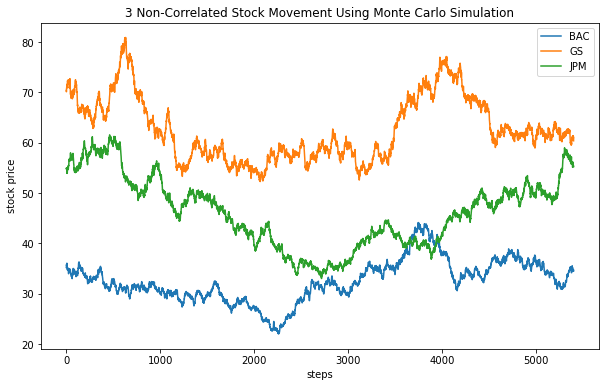

In [9]:
for i in range(int(steps)):
    V = np.random.normal(0,1,len(ticker)) #dame x números aleatorios
    for x in range(len(ticker)):
        values[x] = values[x]*np.exp((summary.Return[x] - 0.5*summary.Risk[x]**2)*delta_t + summary.Risk[x]*np.sqrt(delta_t)*V[x])
        pths["pth%s" %x].append(values[x])

df = pd.DataFrame(pths)
df.columns = corr_matrix.columns
df2 = df#.div(df.iloc[0]).mul(100)

#df.index = days
df2.plot(kind='line',figsize=(10,6))
#plt.yscale('log')
plt.title('3 Non-Correlated Stock Movement Using Monte Carlo Simulation')
plt.ylabel('stock price')
plt.xlabel('steps')
plt.show()

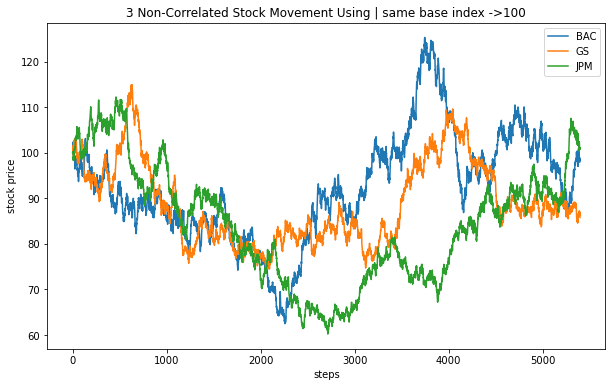

In [17]:
df = pd.DataFrame(pths)
df.columns = corr_matrix.columns
df2 = df.div(df.iloc[0]).mul(100)

#df.index = days
df2.plot(kind='line',figsize=(10,6))
#plt.yscale('log')
plt.title('3 Non-Correlated Stock Movement Using | same base index ->100')
plt.ylabel('stock price')
plt.xlabel('steps')
plt.show()

In [10]:
a= ret.corr()[['BAC']]
a.columns = ['DataSet']
b= df.pct_change().corr()[['BAC']]
Results = pd.DataFrame(a, columns=['DataSet'])
Results['Correlations of paths Non-Correlated'] = b
Results

,DataSet,Correlations of paths Non-Correlated
BAC,1.000000,1.000000
GS,0.652412,-0.007443
JPM,0.782833,0.000913


# 2.2. Correlated Simulation

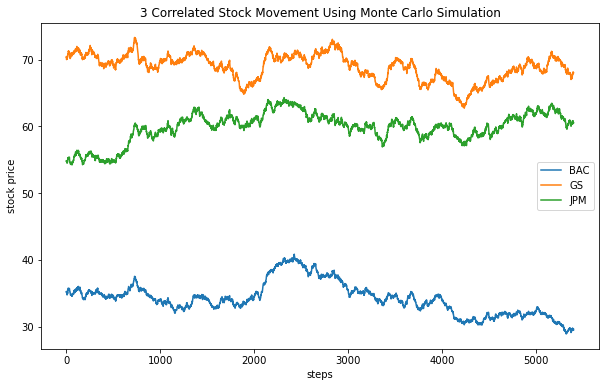

In [11]:
paths = {}
for number in range(0,len(ticker)):
    paths["path%s" %number] = [prices.iloc[0,number]]# Genera lista pathx con fila 0 de precios
values = [i for i in prices.iloc[0]]

for i in range(int(steps)):
    C = L.dot(np.random.normal(0,1,len(ticker))) #dame x números aleatorios
    for x in range(len(ticker)):
        values[x] = values[x]*np.exp((summary.Return[x] - 0.5*summary.Risk[x]**2)*delta_t + summary.Risk[x]*np.sqrt(delta_t)*C[x])
        paths["path%s" %x].append(values[x])

data = pd.DataFrame(paths)
data.columns = corr_matrix.columns
data2 = data#.div(data.iloc[0]).mul(100)

#df.index = days
data2.plot(kind='line',figsize=(10,6))
plt.title('3 Correlated Stock Movement Using Monte Carlo Simulation')
plt.ylabel('stock price')
plt.xlabel('steps')
plt.show()



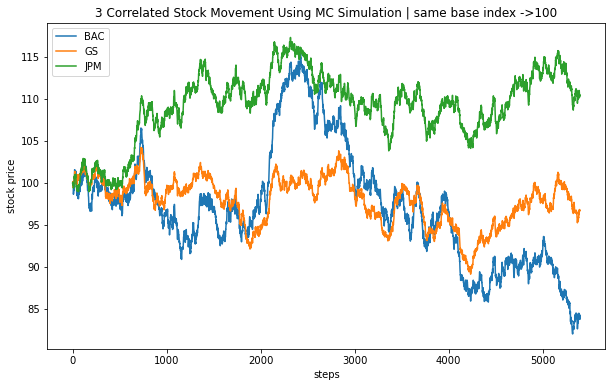

In [16]:
data2 = data.div(data.iloc[0]).mul(100)

#df.index = days
data2.plot(kind='line',figsize=(10,6))
plt.title('3 Correlated Stock Movement Using MC Simulation | same base index ->100')
plt.ylabel('stock price')
plt.xlabel('steps')
plt.show()

In [12]:
c= data.pct_change().corr()[['BAC']]
Results['Correlations of paths Correlated'] = c
Results

,DataSet,Correlations of paths Non-Correlated,Correlations of paths Correlated
BAC,1.000000,1.000000,1.000000
GS,0.652412,-0.007443,0.647723
JPM,0.782833,0.000913,0.782457


# 3. Conclusions

In the previous table, we gathered all the information related to correlations of Dateset with BAC, paths non-correlated, and paths correlated. We can see that our paths correlated follow a simillar correlation than the original dataset after applying Cholesky to our Geometric Brownian Motion.

The following plot shows a heatmap where we see non-correlation at all against BAC from GS and JPM (colour black), and the correlations against BAC from Dateset and and modeled paths correlated are same colour, thus same correlations between each of them.

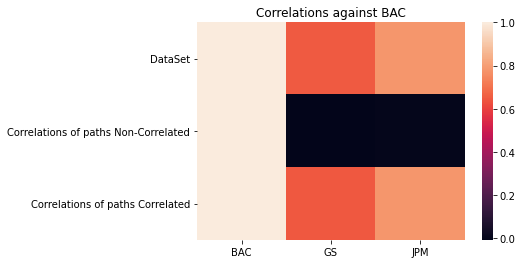

In [20]:
sns.heatmap(Results.T)
plt.title('Correlations of BAC, GS and JPM against BAC')
plt.show()

# 4. Considerations

The previously developed code has reached the debug phase, but it could be simplified a little bit.
After that, the wording phase will be deployed to explain and make the code easier to understand.

Please, if you find this code useful, make use of it under your responsibility.

Carefully,

Alejandro Álvarez, CAd